# Лабораторная работа №5.

In [1]:
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import seaborn as sns
import pandas as pd

Рассматривается задача бинарной классификации. Пусть заданы два
класса, распределение которых является многомерным нормальным ($\mu_+ \in \mathbb R^2$ – параметр положительного класса $(+1)$, $\mu_−$ – отрицательного $(-1)$, $\Sigma \in \mathbb R ^{2\times 2}$ – общая для классов ковариационная матрица).

1. Подобрать параметры распределений таким образом, чтобы классы
немного пересекались (нельзя было разделить их линейной функцией).

In [2]:
cov = np.array([[5, -2], 
                [-2, 4]])
mean_pos = np.array([1, 1])
mean_neg = np.array([-1, -0.5])

2. Сгенерировать по $N = 30$ объектов каждого класса. Разделить данные
каждого класса на 3 равные по объему выборки (тренировочную,
валидационную и тестовую).

In [3]:
np.random.seed(42)

pts_1 = np.random.multivariate_normal(mean_pos, cov, size=30)
pts_2 = np.random.multivariate_normal(mean_neg, cov, size=30)

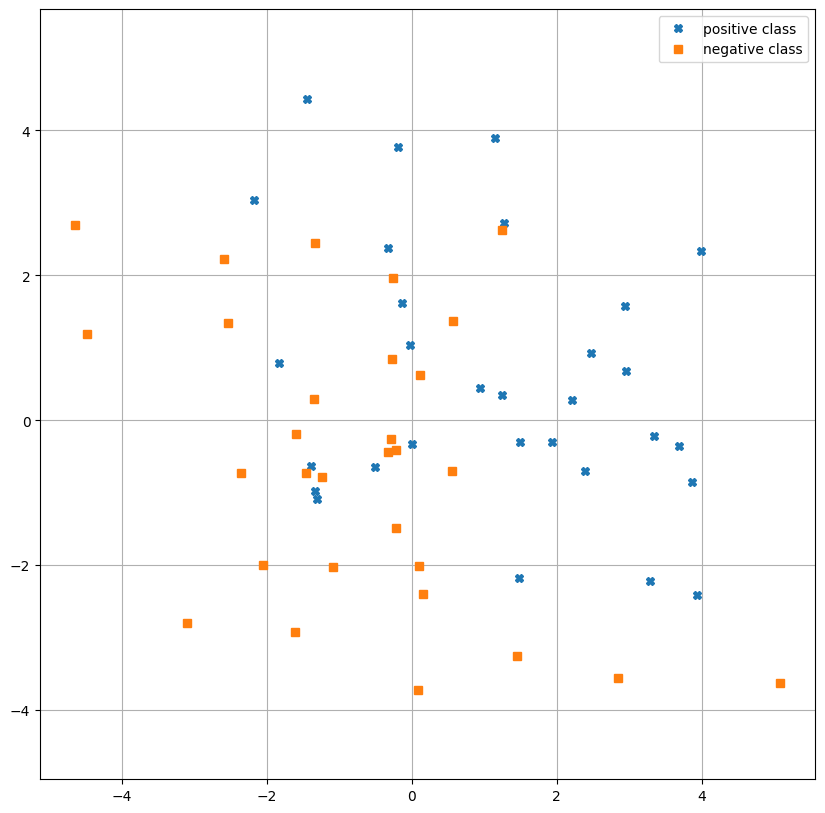

In [4]:
plt.figure(figsize=(10, 10))
plt.plot(pts_1[:, 0], pts_1[:, 1], 'X', label='positive class')
plt.plot(pts_2[:, 0], pts_2[:, 1], 's', label='negative class')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
X = np.concatenate([pts_1, pts_2])

X1_train, X1_val, X1_test = np.split(pts_1, 3)
X2_train, X2_val, X2_test = np.split(pts_2, 3)

X_train = np.concatenate([X1_train, X2_train])
y_train = np.concatenate([np.zeros(len(X1_train)), np.ones(len(X2_train))])

X_val = np.concatenate([X1_val, X2_val])
y_val = np.concatenate([np.zeros(len(X1_val)), np.ones(len(X2_val))])

X_test = np.concatenate([X1_test, X2_test])
y_test = np.concatenate([np.zeros(len(X1_test)), np.ones(len(X2_test))])

3. Реализовать и обучить модель логистической регрессии (логику
написать самим). Построить на графике полученную разделяющую
поверхность. Для нескольких объектов из обоих классов вывести оценки
вероятностей их распределения по классам.

Функция $$\sigma (z) = \dfrac{1}{1+e^{-z}}$$ со значениями из отрезка $[0, 1]$ называется **сигмоидой**. Эту функцию мы будем применять для получения вероятностей принадлежности объекта классу. 

Мы также будем использовать два свойства этой функици:

1) $1-\sigma(z) = \sigma(-z)$;

2) $\sigma ' (z) = \sigma(z)(1-\sigma(z)$.

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Функция вида
$$Loss = \dfrac{1}{N} \sum_{i=k}^N y_k \ln \hat y_k + (1-y_k)\ln (1-\hat y_k),$$ называется **кросс-энтропией** и является целевой функцией в задаче двухклассовой классификации; здесь $y_i$ -- реальная метка класса, а $\hat y_i$ -- спрогнозированная метка класса. То есть для решения задачи классификации мы должны решить задачу оптимизации 
$$\dfrac{1}{N} \sum_{i=1}^N y_i \ln \hat y_i + (1-y_i)\ln (1-\hat y_i) \to \min.$$

In [7]:
def cross_entropy_loss(y_pred, y_true):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

Итак, мы имеем на входе $N\times M$ матрицу признаков $X$ и вектор меток классов $y$. Для реализации модели логистической регрессии мы вводим вектор весов $$w = (w_0,\ldots, w_M),$$ который инициализируем некоторыми начальными значениями из равномерного распределения на отрезке $[0,1]$. Мы предполагаем, что истинную метку класса для объекта можно получить как
$$\hat y_k = \sigma(x^T_k w) = \dfrac{1}{1+e^{-x_k^Tw}},$$ где $$x_k \in \mathbb R^M$$ -- это вектор признаков $k$-ого объекта с меткой $y_k$.

Для обучения модели будем использовать градиентный спуск. Но для этого нам нужно вычислить, чему будет равен градиент от целевой функции. Так как можно выразить функцию потерь в виде
$$Loss = \dfrac{1}{N} \sum_{i=k}^N y_k \ln \sigma(x_k^Tw) + (1-y_k)\ln (1-\sigma(x_k^Tw)) = \dfrac{1}{N} \sum_{i=k}^N y_k \ln \sigma(x_k^Tw) + (1-y_k)\ln \sigma(-x_k^Tw),$$
то
$$\dfrac{\partial Loss}{\partial w} = \dfrac{1}{N} \sum_{i=k}^N x_k^T\cdot y_k\cdot \dfrac{1}{\sigma(x_k^Tw)} \cdot \sigma(x_k^Tw)\cdot \sigma(-x_k^Tw) - x_k^T (1-y_k)\cdot \dfrac{1}{\sigma(-x_k^Tw)}\cdot \sigma(-x_k^Tw)\cdot \sigma(x_k^Tw) = \dfrac{1}{N} \sum_{i=k}^N x_k^T y_k(1 - \sigma(x_k^Tw)) - (1-y_k)\sigma(x_k^Tw) = \dfrac 1 N \sum_{k=1}^N x_k^T (y_k - \sigma(x_k^Tw)).$$
А тогда, если записать это в векторном виде, то
$$\dfrac{\partial Loss}{\partial w} = \dfrac1N X^T(y - \sigma (Xw)).$$ Таким образом, градиентный спуск определим следующим образом:
$$\dfrac{\partial Loss}{\partial w_j} = \dfrac1N X^T(y - \sigma (Xw_j)),$$
$$w_{j+1} = w_j -\alpha \cdot \dfrac{\partial L}{\partial w_j},\ j=0,1,\ldots,$$
где $\alpha$ -- это некоторый параметр, называемый шагом обучения. Мы будем считать $\alpha = 0.01$. 

Пусть $j=\overline{0,1000}$.

In [8]:
class LogisticRegression():
    def __init__(self, n_iterations = 1000, lr = 0.01):
        self.n_iterations = n_iterations
        self.lr = lr
        self.weights = None
    
    def fit(self, X, y):
        X_const = np.hstack((np.ones((X.shape[0], 1)), X))
        n_samples, n_features = X_const.shape
        self.weights = np.random.uniform(size=n_features)
        
        losses = []
        for i in range(self.n_iterations):
        
            z = np.dot(X_const, self.weights)
            y_pred = sigmoid(z)
            
            grad = np.dot(X_const.T, (y_pred - y)) / n_samples
            
            self.weights -= self.lr * grad
            loss = cross_entropy_loss(y_pred, y)
            losses.append(loss)
        
        return losses
	
    def predict(self, X):
        if len(X.shape) == 1:
            X_const = np.hstack((np.ones((np.array([X]).shape[0], 1)), np.array([X])))
        else :
            X_const = np.hstack((np.ones((X.shape[0], 1)), X))
        return sigmoid(np.dot(X_const, self.weights))

In [9]:
model = LogisticRegression()
losses = model.fit(X_train, y_train)

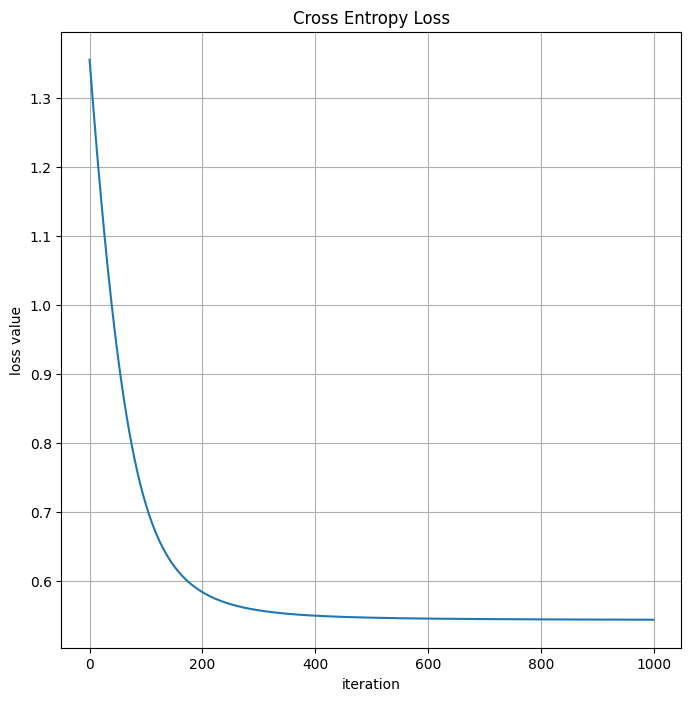

In [10]:
plt.figure(figsize=(8, 8))
plt.title('Cross Entropy Loss')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.plot(losses)
plt.grid(True)
plt.show()

In [11]:
def sep_hyperplane(x, y):
    return model.weights[0] + model.weights[1]*x + model.weights[2]*y

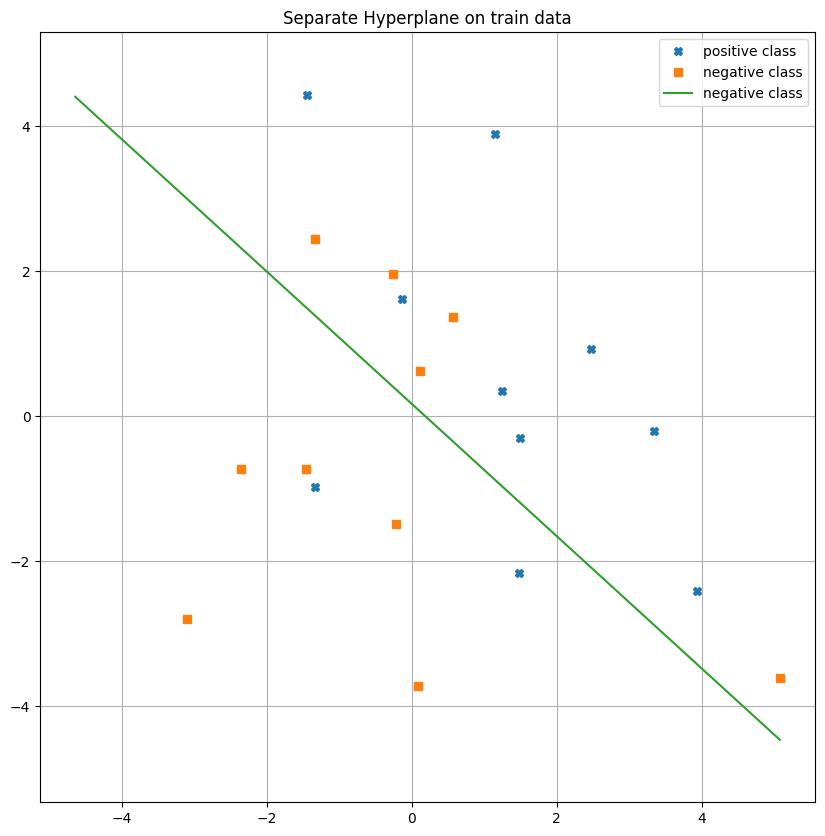

In [12]:
x = np.linspace(min(X[:, 0]), max(X[:, 0]), 10)
y = np.linspace(min(X[:, 1]), max(X[:, 1]), 10)
plt.figure(figsize=(10, 10))
plt.plot(X1_train[:, 0], X1_train[:, 1], 'X', label='positive class')
plt.plot(X2_train[:, 0], X2_train[:, 1], 's', label='negative class')
plt.plot(x, sep_hyperplane(x, y), label='negative class')
plt.axis('equal')
plt.title('Separate Hyperplane on train data')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
y_train_pred = model.predict(X_train)
pd.DataFrame([y_train, 
              y_train_pred, 
              y_train - np.round(y_train_pred, 0) != y_train]).T.rename(columns={0 : 'true label', 1 : 'predict proba', 2 : 'Error'})

,true label,predict proba,Error
0,0.0,0.408658,False
1,0.0,0.112898,False
2,0.0,0.356076,False
3,0.0,0.299863,False
4,0.0,0.17957,False
5,0.0,0.389599,False
6,0.0,0.801674,True
7,0.0,0.287667,False
8,0.0,0.17965,False
9,0.0,0.588042,True


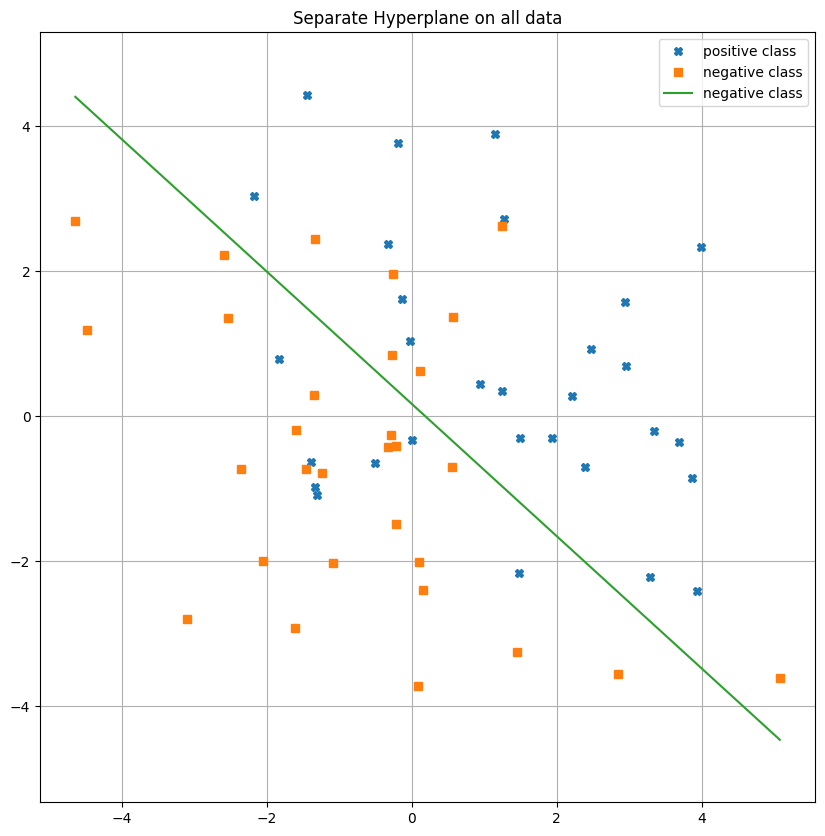

In [14]:
x = np.linspace(min(X[:, 0]), max(X[:, 0]), 10)
y = np.linspace(min(X[:, 1]), max(X[:, 1]), 10)
plt.figure(figsize=(10, 10))
plt.plot(pts_1[:, 0], pts_1[:, 1], 'X', label='positive class')
plt.plot(pts_2[:, 0], pts_2[:, 1], 's', label='negative class')
plt.plot(x, sep_hyperplane(x, y), label='negative class')
plt.axis('equal')
plt.title('Separate Hyperplane on all data')
plt.grid(True)
plt.legend()
plt.show()

4. Определить оптимальный порог $t$, при котором на валидационной
выборке определяются не менее $60\%$ от поступающих положительных
объектов:
$$\hat p (y = +1 | x) \equiv a(x) > t.$$


Для этого поступим следующим образом:

1. Отсортируем массив вероятностей по убыванию, чтобы было проще перебирать пороги $t$ на каждом шаге.

2. Для каждого порога $t$, начиная с наибольшего значения вероятности, подсчитываем количество правильно предсказанных положительных объектов.

3. Вычисляем для каждого порога $$True\ Positive\ Rate = \dfrac{True\ Positive}{All\ positive\ objects}$$ и проверяем выполняется ли условие.

In [15]:
def find_optimal_threshold(probabilities, labels, min_tpr=0.6):
    sorted_indices = np.argsort(-probabilities)
    probabilities = probabilities[sorted_indices]
    labels = labels[sorted_indices]
    
    total_positives = np.sum(labels)
    if total_positives == 0:
        raise ValueError
    
    true_positives = 0
    for i, prob in enumerate(probabilities):
        if labels[i] == 1:
            true_positives += 1
        tpr = true_positives / total_positives
        if tpr >= min_tpr:
            return prob
    
    return None


optimal_threshold = find_optimal_threshold(model.predict(X_val), y_val, min_tpr=0.6)
print(f"Оптимальный порог t = {optimal_threshold}")

Оптимальный порог t = 0.7404495981000175


5. На тестовой выборке оценить качество полученного алгоритма,
рассчитав метрики (расчет метрик реализовать самим):
1) Accuracy;

2) Матрица ошибок;

3) Precision, Recall;

4) ROC – кривая, ROC-AUC.

In [16]:
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba, 0)

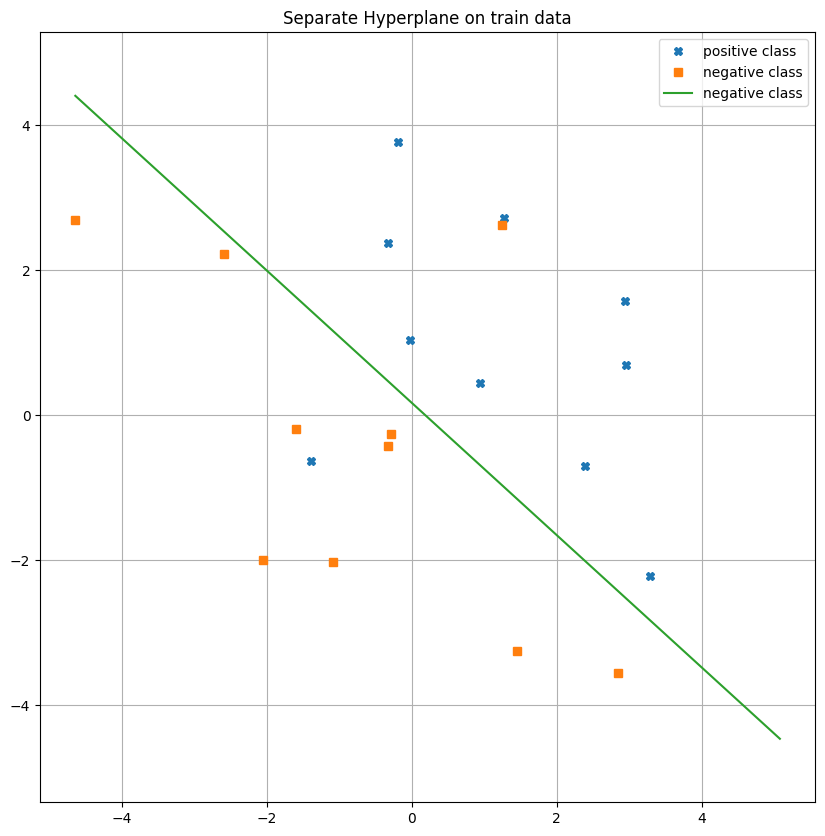

In [19]:
x = np.linspace(min(X[:, 0]), max(X[:, 0]), 10)
y = np.linspace(min(X[:, 1]), max(X[:, 1]), 10)
plt.figure(figsize=(10, 10))
plt.plot(X1_test[:, 0], X1_test[:, 1], 'X', label='positive class')
plt.plot(X2_test[:, 0], X2_test[:, 1], 's', label='negative class')
plt.plot(x, sep_hyperplane(x, y), label='negative class')
plt.axis('equal')
plt.title('Separate Hyperplane on train data')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
TP = np.sum((y_pred == 1) & (y_test == 1))
TN = np.sum((y_pred == 0) & (y_test == 0))
FP = np.sum((y_pred == 1) & (y_test == 0))
FN = np.sum((y_pred == 0) & (y_test == 1))

Accuracy (точность) — доля правильно классифицированных объектов:
$$\operatorname{Accuracy} = \dfrac{TP + TN}{TP + TN+FP + FN} = \dfrac 1 N \sum_{k=1}^N [y_k = \hat y_k]$$

In [26]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.9

Матрица ошибок (confusion matrix) — таблица, отражающая распределение предсказаний:
$$\begin{bmatrix}TP & FN \\ FP & FN\end{bmatrix}$$

In [27]:
confusion_matrix = np.array([[TP, FN], [FP, TN]])
confusion_matrix

array([[9, 1],
       [1, 9]])

Precision (точность положительных предсказаний) — доля правильно классифицированных положительных объектов среди всех предсказанных положительными:
$$\operatorname{Precision} = \dfrac{TP}{TP + FP}.$$
Recall (полнота) — доля правильно классифицированных положительных объектов среди всех истинных положительных:
$$\operatorname{Recall} = \dfrac{TP}{TP + FN}.$$

In [29]:
precision = TP / (TP + FP)
precision

0.9

In [30]:
recall = TP / (TP + FN)
recall

0.9

ROC-кривая (Receiver Operating Characteristic) строится как зависимость True Positive Rate (TPR) от False Positive Rate (FPR) при варьировании порога $t$:
$$\operatorname{TPR} = \dfrac{TP}{TP + FN},\ \operatorname{FPR} = \dfrac{FP}{FP + TN}.$$
ROC-AUC (Area Under the Curve) — площадь под ROC-кривой. Это обобщенная метрика качества, оценивающая способность модели разделять классы.

In [36]:
from sklearn.metrics import auc

thresholds = np.sort(y_pred_proba)[::-1]
tpr_list = []
fpr_list = []

for t in thresholds:
    y_pred_threshold = (y_pred_proba >= t).astype(int)
    TP_t = np.sum((y_pred_threshold == 1) & (y_test == 1))
    TN_t = np.sum((y_pred_threshold == 0) & (y_test == 0))
    FP_t = np.sum((y_pred_threshold == 1) & (y_test == 0))
    FN_t = np.sum((y_pred_threshold == 0) & (y_test == 1))
    
    TPR = TP_t / (TP_t + FN_t) if (TP_t + FN_t) > 0 else 0
    FPR = FP_t / (FP_t + TN_t) if (FP_t + TN_t) > 0 else 0
    
    tpr_list.append(TPR)
    fpr_list.append(FPR)

roc_auc = auc(fpr_list, tpr_list)

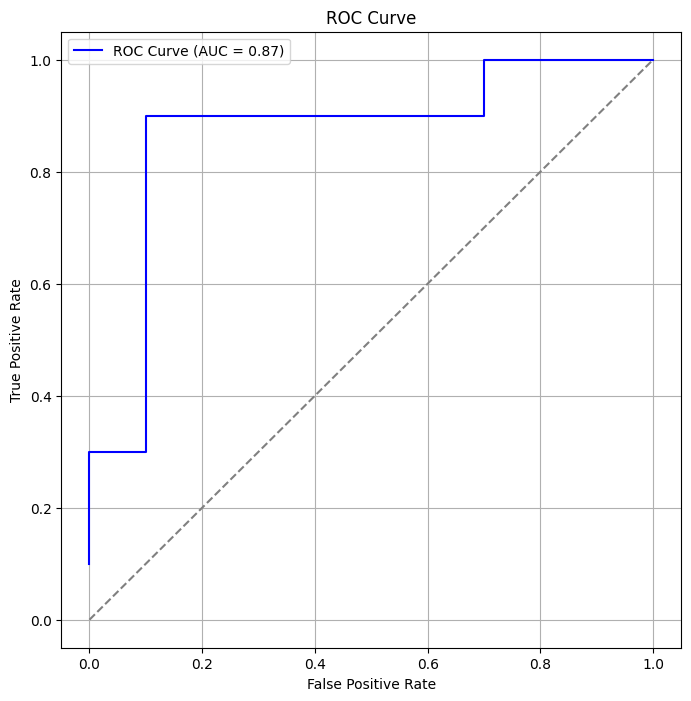

In [39]:
plt.figure(figsize=(8, 8))
plt.plot(fpr_list, tpr_list, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()